# Analysis: Home Credit

Included below is is an example of our inferential analysis using logistic regression, support vector macheines, and linear discriminant analysis applied to a just over 300k unique loans from past Home Credit clients. We aim to analyze different cross-validation processes (completely random split, stratified split, and income level split) across multiple combinations of features using the three specified models to accuratly classify future clients as will pay back, will not pay back, and could go either way.

## Setup

We use the following packages:
- `pandas` as a tool for tabular and relational data engineering
- `numpy` as a tool for vectorized mathematical operations
- `matplotlib` as a visualization tool
- `seaborn` as a visualization tool
- `sklearn` as a tool for model fitting and predictions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pandas.core.frame import DataFrame
from pandas.core.series import Series
from numpy.core.multiarray import ndarray

Here, we suppress unneccesary warnings for cleaner output.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Data Collection

### Home Credit Applications

From Kaggle, we can directly download the [Home Credit Applications](https://www.kaggle.com/competitions/home-credit-default-risk/data?select=HomeCredit_columns_description.csv) dataset.

We then stored this data in dropbox to allow for easy accessability.

In [ ]:
df_app = pd.read_csv("https://www.dropbox.com/scl/fi/kw9qm7c4qo279tikkawzg/application_train.csv?rlkey=2ki8vh99q40hq46r553dclkrz&dl=1")

In [ ]:
df_app.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Past Loan History

We want include variables regarding clients past loan history with Home Credit as well as other companies since this could expose a pattern in repayment history. This data was also collected from the same [Kaggle](https://www.kaggle.com/competitions/home-credit-default-risk/data?select=HomeCredit_columns_description.csv) database (previous_application.csv and bureau.csv). This includes information on a clients past loan history with Home credit as well as other financial institutinos that were reported to the Credit Bureau. Again, these datasets were stoed in dropbox for convenience.

In [ ]:
df_prev = pd.read_csv("https://www.dropbox.com/scl/fi/3s22g0fpb51wf663d1idv/previous_application.csv?rlkey=frrtxo9r8focv1xa254irzjml&dl=1")
df_bureau = pd.read_csv("https://www.dropbox.com/scl/fi/ob456d4upjvxqtafje8jd/bureau.csv?rlkey=uw5f34sxmzrxje0blq01sxls1&dl=1")

In [ ]:
df_prev.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


In [ ]:
df_bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


## Feature Engineering

### Defining Functions

We define custom functions here to apply in a vectorized manner to existing columns, in order to engineer new features.

- `dropNa`: Takes a data frame and drops any columns with X% or more of the records containing missing data.

- `occupation_type_cat`: Simplifies occupation types into fewer categories.

- `organization_type_cat`: Simplifies organization types into fewer categories.


In [ ]:
def dropNA(df, pct):
  percent_missing = pd.DataFrame(df.isna().sum() / len(df))
  percent_missing = percent_missing.sort_values(by = 0, ascending=False)
  columns_super_missing =  percent_missing[percent_missing[0] > pct].index.values.tolist()
  df.drop(columns_super_missing, axis = 1, inplace=True)

In [ ]:
def occupation_type_cat(occ):
  occ_categories = {
      "Staff": ["staff"],
      "Laborer": ["laborer"]
  }

  for category, keywords in occ_categories.items():
      for keyword in keywords:
        try:
          if keyword.lower() in occ.lower():
              return category
        except:
          return "Other"
  return "Other"

In [ ]:
def organization_type_cat(org):
  org_categories = {
      "Business": ["Business Entity", "Trade", "Industry",
                    "Construction", "Restaurant", "Services", "Advertising",
                    "Realtor", "Legal Services", "Cleaning"],
      "Government/Public Sector": ["Government", "Security", "Housing",
                                    "Military", "Bank", "Police", "Postal",
                                    "Security Ministries"],
      "Education": ["School", "Kindergarten", "University"],
      "Transportation/Utilities": ["Transport", "Electricity", "Telecom",
                                    "Emergency"],
      "Healthcare/Agriculture": ["Agriculture", "Medicine"],
      "Self-Employed": ["Self-employed"],
      "Unknown": ["XNA"]
  }

  for category, keywords in org_categories.items():
      for keyword in keywords:
        try:
          if keyword.lower() in org.lower():
              return category
        except:
          return "Other"
  return "Other"

### Feature Creation/Manipulation

First, we clean the application data with the following steps:
- Drop columns with 45% or more rows containing missing values. We do this so that we are confident that the features we select are representative of the whole popultion.
  - This ended up removing 49 features (122 features --> 73 features)
- Fill missing numberic values with the average value and fill categorical values with the mode value.
- Compute the correlation between each pair of features. If two features have high correlation, we calculated the VIF scores through Random Forests and selected the better feature.
  - This ended up removing 9 features (73 features --> 64 features)
- Filterting dataset to only contain interested features
  - Features were selected following exploratory analysis using histograms, bar graphs, and basic insight on what might be useful.

\begin{array}{c} \hline
  \text{Feature of Interest} & \text{Column Name} & \text{Description} \\ \hline
  \text{Total Income} & \text{AMT_INCOME_TOTAL} & \text{The amount of monthly total income, self-reported by the applicant} \\
  & & & \\
  \text{Loan Annuity} & \text{AMT_ANNUITY} & \text{Loan annuity amount} \\
  & & & \\
  \text{Occupation Type} & \text{OCCUPATION_TYPE} & \text{The broad category of work done by the applicant} \\
  & & & \\
  \text{Education Level} & \text{NAME_EDUCATION_TYPE} & \text{Level of highest education the applicant achieved} \\
  & & & \\
  \text{Credit Bureau Enquiries} & \text{AMT_REQ_CREDIT_BUREAU_[HOUR/DAY/WEEK/MON/QRT/YEAR]} & \text{The total number of inquiries made about the applicant to} \\
  & & \text{the Credit Bureau X before the aplpication, excluding shorter time frames} \\
  & & & \\
  \text{Application Details} & \text{WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START} & \text{Time and day the applicant began their process} \\
  & & & \\
  \text{Marriage Status} & \text{NAME_FAMILY_STATUS} & \text{The status of the applicant’s relationship} \\
  & & & \\
  \text{Organization Type} & \text{ORGANIZATION_TYPE} & \text{The type of industry the applicant is employed in} \\
  & & & \\
  \text{Days Employed} & \text{DAYS_EMPLOYED} & \text{Number of days the applicant has been with current job} \\
  & & & \\
  \text{Loan Type} & \text{NAME_CONTRACT_TYPE} & \text{Whether the loan is for a lump-sum of cash or revolving credit} \\ \hline
\end{array}

    


In [ ]:
# Drop cols with lots of missing values
dropNA(df_app, .45)

In [ ]:
# replace missing values in numeric cols with mean
for column in df_app.columns:
    if set(df_app[column].unique()).issubset({0, 1}):
        df_app[column] = df_app[column].astype(bool)
for column in df_app.select_dtypes(include=[np.number]).columns:
    df_app[column] = df_app[column].fillna(df_app[column].mean())

In [ ]:
# replace missing values in categorical cols with mode
for column in df_app.select_dtypes(include=['object', 'category']).columns:
    mode_value = df_app[column].mode()[0]
    df_app[column] = df_app[column].fillna(mode_value)

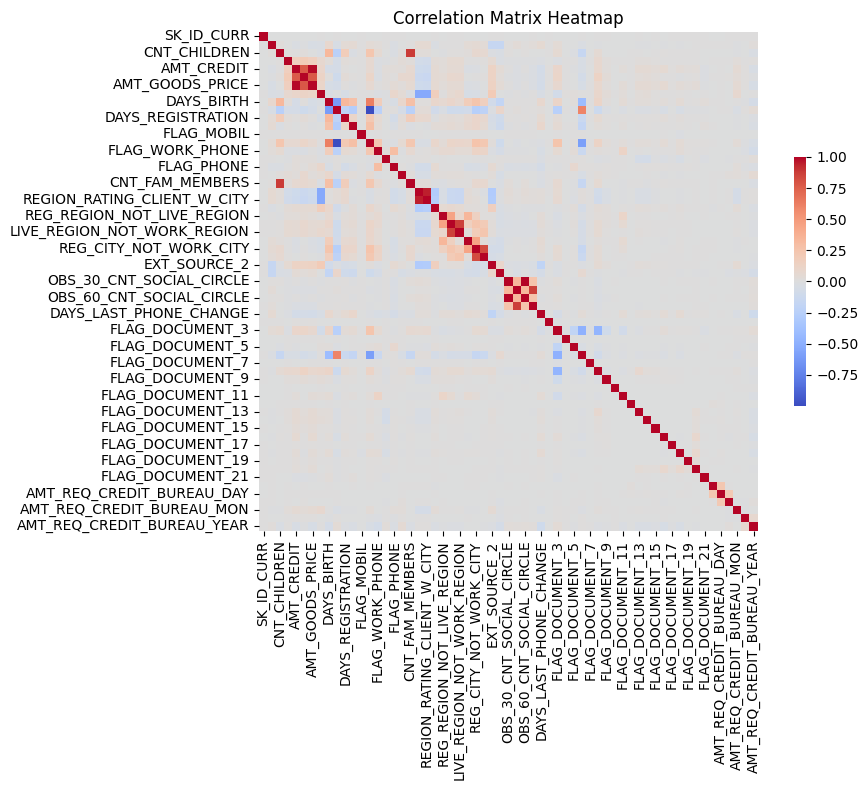

In [ ]:
# Check correlation between cols
corr = df_app.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [ ]:
upper = corr.where(pd.np.triu(pd.np.ones(corr.shape), k=1).astype(bool))
correlation_pairs = upper.unstack()
correlation_pairs = correlation_pairs.dropna()

sorted_pairs = correlation_pairs.sort_values(kind="quicksort", ascending=False)

threshold = 0.7
high_correlation_pairs = sorted_pairs[sorted_pairs.abs() > threshold]

high_correlation_pairs

OBS_60_CNT_SOCIAL_CIRCLE     OBS_30_CNT_SOCIAL_CIRCLE      0.998490
AMT_GOODS_PRICE              AMT_CREDIT                    0.986588
REGION_RATING_CLIENT_W_CITY  REGION_RATING_CLIENT          0.950842
CNT_FAM_MEMBERS              CNT_CHILDREN                  0.879160
LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION    0.860627
DEF_60_CNT_SOCIAL_CIRCLE     DEF_30_CNT_SOCIAL_CIRCLE      0.860517
LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY        0.825575
AMT_GOODS_PRICE              AMT_ANNUITY                   0.774661
AMT_ANNUITY                  AMT_CREDIT                    0.770127
FLAG_EMP_PHONE               DAYS_EMPLOYED                -0.999755
dtype: float64

In [ ]:
X = df_app.drop('TARGET', axis=1)
y = df_app['TARGET']

X = pd.get_dummies(X, drop_first=True)

np.random.seed(42)

test_size = 0.2
num_test_samples = int(len(X) * test_size)

shuffled_indices = np.random.permutation(len(X))

test_indices = shuffled_indices[:num_test_samples]
train_indices = shuffled_indices[num_test_samples:]



X_train = X.iloc[train_indices]
X_test = X.iloc[test_indices]
y_train = y.iloc[train_indices]
y_test = y.iloc[test_indices]

# Random Forest
rf = RandomForestRegressor(n_estimators=20, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


print(feature_importances)

                       Feature  Importance
27                EXT_SOURCE_2    0.081627
28                EXT_SOURCE_3    0.065019
9            DAYS_REGISTRATION    0.053780
0                   SK_ID_CURR    0.052947
7                   DAYS_BIRTH    0.052075
..                         ...         ...
62             CODE_GENDER_XNA    0.000000
85  NAME_FAMILY_STATUS_Unknown    0.000000
42            FLAG_DOCUMENT_10    0.000000
11                  FLAG_MOBIL    0.000000
44            FLAG_DOCUMENT_12    0.000000

[172 rows x 2 columns]


In [ ]:
feature_importances = pd.DataFrame(feature_importances)

importance_dict = feature_importances.set_index('Feature')['Importance'].to_dict()
features_to_drop = set()


for (feature1, feature2), corr_value in high_correlation_pairs.items():
    importance1 = importance_dict.get(feature1, 0)
    importance2 = importance_dict.get(feature2, 0)

    # Add the less important feature to the drop list
    if importance1 < importance2:
        features_to_drop.add(feature1)
    else:
        features_to_drop.add(feature2)

df_app_reduced = df_app.drop(columns=list(features_to_drop))

print(f"Features to drop: {features_to_drop}")

Features to drop: {'REGION_RATING_CLIENT', 'DEF_60_CNT_SOCIAL_CIRCLE', 'REG_CITY_NOT_WORK_CITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'CNT_CHILDREN', 'FLAG_EMP_PHONE', 'REG_REGION_NOT_WORK_REGION', 'OBS_60_CNT_SOCIAL_CIRCLE'}


In [ ]:
filtered_features = ['SK_ID_CURR', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY',
        'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER', 'LIVE_CITY_NOT_WORK_CITY',
        'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
        'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED',
        'NAME_CONTRACT_TYPE']
df_app_filtered = df_app_reduced[filtered_features]

Next, we develop and clean the following features:
\begin{array}{c} \hline
  \text{Feature of Interest} & \text{Column Name} & \text{Description} \\ \hline
  \text{Occupation Type} & \text{OCCUPATION_TYPE_CAT} & \text{The broad category of work done by the applicant} \\
  \text{Education Level} & \text{COLLEGE_FLAG} & \text{Whether the applicant has a college degree or not} \\
  \text{Credit Bureau Enquiries} & \text{TOTAL_CLAIMS} & \text{The total number of inquiries made about the applicant to the Credit Bureau} \\
  \text{Organization Type} & \text{ORGANIZATION_TYPE_CAT} & \text{The type of industry the applicant is employed in} \\
  \text{Loan Type} & \text{NAME_CONTRACT_TYPE_FLAG} & \text{Whether the loan is for a lump-sum of cash (1) or revolving credit (0)} \\
  \text{Gender} & \text{GENDER_FLAG} & \text{Gender of applicant (1 if Female, 0 if Male)} \\
  \text{Commute} & \text{LIVE_CITY_NOT_WORK_CITY_FLAG} & \text{Whether applicants contact addresses city matches their work addresses city (1 if different, 0 if same)} \\
  \hline
\end{array}



<Axes: xlabel='OCCUPATION_TYPE_CAT'>

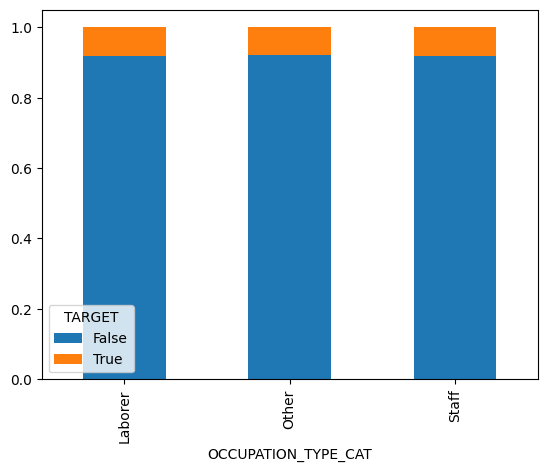

In [ ]:
df_app_filtered['OCCUPATION_TYPE_CAT'] = df_app_filtered['OCCUPATION_TYPE'].map(occupation_type_cat)
df_app_filtered.groupby('OCCUPATION_TYPE_CAT')['TARGET'].value_counts(normalize=True).unstack().fillna(0).plot.bar(stacked=True)

<Axes: xlabel='COLLEGE_FLAG'>

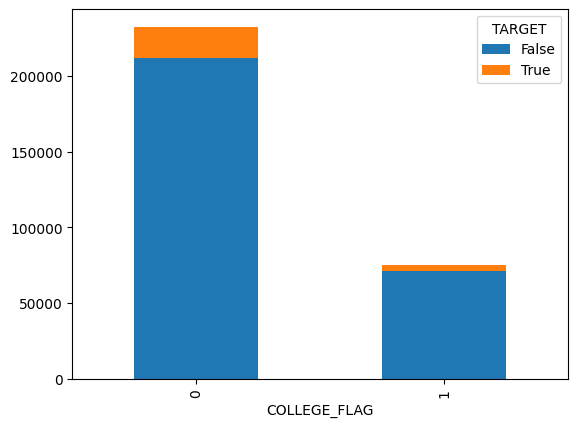

In [ ]:
df_app_filtered['COLLEGE_FLAG'] = df_app_filtered['NAME_EDUCATION_TYPE'].map(lambda edu: 1 if edu in ["Higher education", "Academic degree"] else 0)
df_app_filtered.groupby('COLLEGE_FLAG')['TARGET'].value_counts(normalize=False).unstack().fillna(0).plot.bar(stacked=True)

<Axes: xlabel='TOTAL_CLAIMS'>

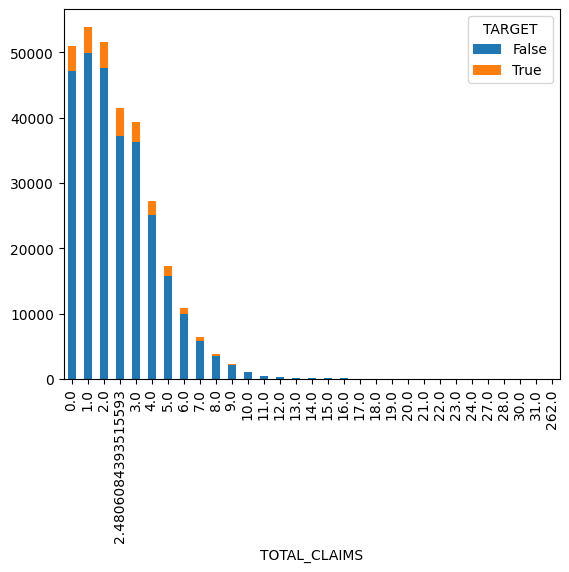

In [ ]:
df_app_filtered['TOTAL_CLAIMS'] = df_app_filtered[
    ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
     'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
     'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
    ].sum(axis=1)
df_app_filtered.groupby('TOTAL_CLAIMS')['TARGET'].value_counts(normalize=False).unstack().fillna(0).plot.bar(stacked=True)

<Axes: xlabel='ORGANIZATION_TYPE_CAT'>

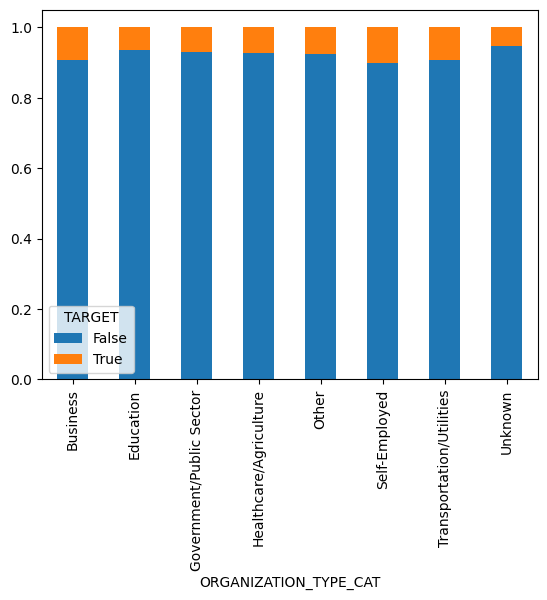

In [ ]:
df_app_filtered['ORGANIZATION_TYPE_CAT'] = df_app_filtered['ORGANIZATION_TYPE'].str.split(':').str[0].str.split('Type').str[0].str.strip()
df_app_filtered['ORGANIZATION_TYPE_CAT'] = df_app_filtered['ORGANIZATION_TYPE_CAT'].map(organization_type_cat)
df_app_filtered.groupby('ORGANIZATION_TYPE_CAT')['TARGET'].value_counts(normalize=True).unstack().fillna(0).plot.bar(stacked=True)

In [ ]:
df_app_filtered['NAME_CONTRACT_TYPE_FLAG'] = df_app_filtered['NAME_CONTRACT_TYPE'].map(lambda x: 1 if x == 'Cash loans' else 0)
df_app_filtered['GENDER_FLAG'] = df_app_filtered['CODE_GENDER'].map(lambda x: 1 if x == 'F' else 0)
df_app_filtered['LIVE_CITY_NOT_WORK_CITY_FLAG'] = df_app_filtered['LIVE_CITY_NOT_WORK_CITY'].map(lambda x: 1 if x else 0)

We dropped the columns used to create the above features since they are no longer of use:

In [ ]:
df_app_filtered.drop('OCCUPATION_TYPE', axis=1, inplace=True)
df_app_filtered.drop('NAME_EDUCATION_TYPE', axis=1, inplace=True)
df_app_filtered.drop(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
     'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
     'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1, inplace=True)
df_app_filtered.drop('ORGANIZATION_TYPE', axis=1, inplace=True)
df_app_filtered.drop('NAME_CONTRACT_TYPE', axis=1, inplace=True)
df_app_filtered.drop('CODE_GENDER', axis=1, inplace=True)
df_app_filtered.drop('LIVE_CITY_NOT_WORK_CITY', axis=1, inplace=True)

Finally, we create and clean features utilizing past loans:

\begin{array}{c} \hline
  \text{Feature of Interest} & \text{Column Name} & \text{Description} \\ \hline
  \text{Previous Loan Applications} & \text{CNT_PREV_TOTAL} & \text{Sum of the amount of past loan applications per applicant} \\ \hline
  \text{Previous Loan Amounts} & \text{SUM_AMT_CREDIT} & \text{Sum of the amount of past applicant's loans} \\ \hline
  \text{Previous Loan Approvals} & \text{APPROVAL} & \text{Worst outcome of all previous loan applications} \\ \hline
  \text{Previous Overdue Amounts} & \text{OVERDUE_AMOUNT} & \text{Total amount overdue on all loans} \\ \hline
  \text{Ongoing and Recent Loans} & \text{END_DATES} & \text{Maximum number of days remaining on a loan} \\
\end{array}

<Axes: xlabel='CNT_PREV_TOTAL'>

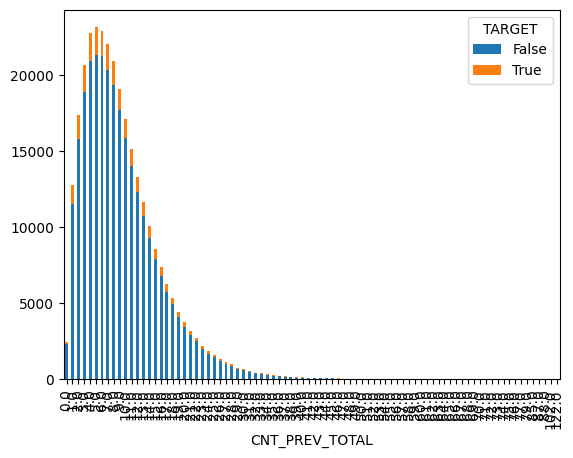

In [ ]:
df_app_filtered['CNT_PREV_TOTAL'] = df_app_filtered['SK_ID_CURR'].map(df_prev['SK_ID_CURR'].value_counts()).fillna(0) + df_app_filtered['SK_ID_CURR'].map(df_bureau['SK_ID_CURR'].value_counts()).fillna(0)
df_app_filtered.groupby('CNT_PREV_TOTAL')['TARGET'].value_counts(normalize=False).unstack().fillna(0).plot.bar(stacked=True)

In [ ]:
df_prev_reduced = df_prev[['SK_ID_CURR', 'NAME_CONTRACT_STATUS', 'AMT_CREDIT']]
df_bureau_reduced = df_bureau[['SK_ID_CURR', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM_OVERDUE']]

In [ ]:
prev_apps = df_prev_reduced.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].count()
sum_amt_credit = df_prev_reduced.groupby('SK_ID_CURR')['AMT_CREDIT'].sum()
approval = df_prev_reduced.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].max()

In [ ]:
end_dates = df_bureau_reduced.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
overdue_amount = df_bureau_reduced.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum()

In [ ]:
d = pd.DataFrame()
d['PREV_APPS'] = prev_apps
d['SUM_AMT_CREDIT'] = sum_amt_credit
d['APPROVAL'] = approval
d['END_DATES'] = end_dates
d['OVERDUE_AMOUNT'] = overdue_amount

In [ ]:
# replace missing values in numeric cols with mean
for column in d.columns:
    if set(d[column].unique()).issubset({0, 1}):
        d[column] = d[column].astype(bool)
for column in d.select_dtypes(include=[np.number]).columns:
    d[column] = d[column].fillna(d[column].mean())

# replace missing values in categorical cols with mode
for column in d.select_dtypes(include=['object', 'category']).columns:
    mode_value = d[column].mode()[0]
    d[column] = d[column].fillna(mode_value)

In [ ]:
df_app_filtered = df_app_filtered.merge(d, on = 'SK_ID_CURR', how='left')
df_app_filtered['APPROVAL'] = df_app_filtered['APPROVAL'].fillna('None')
df_app_filtered = df_app_filtered.fillna(0)

### Save Data to CSV

In [ ]:
df_app_filtered.to_csv("home_credit.csv", index=False)
df_app_filtered.head(3)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_ANNUITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,NAME_FAMILY_STATUS,DAYS_EMPLOYED,OCCUPATION_TYPE_CAT,COLLEGE_FLAG,...,ORGANIZATION_TYPE_CAT,NAME_CONTRACT_TYPE_FLAG,GENDER_FLAG,LIVE_CITY_NOT_WORK_CITY_FLAG,CNT_PREV_TOTAL,PREV_APPS,SUM_AMT_CREDIT,APPROVAL,END_DATES,OVERDUE_AMOUNT
0,100002,True,202500.0,24700.5,WEDNESDAY,10,Single / not married,-637,Laborer,0,...,Business,1,0,0,9.0,1.0,179055.0,Approved,780.0,0.0
1,100003,False,270000.0,35698.5,MONDAY,11,Married,-1188,Staff,1,...,Education,1,1,0,7.0,3.0,1452573.0,Approved,1216.0,0.0
2,100004,False,67500.0,6750.0,MONDAY,9,Single / not married,-225,Laborer,0,...,Government/Public Sector,0,0,0,3.0,1.0,20106.0,Approved,-382.0,0.0


## Model Fitting

### Data

In [5]:
model_data = pd.read_csv("https://www.dropbox.com/scl/fi/fnpat3yonykvdlehg5xqk/home_credit.csv?rlkey=e2x8r2bwp1je1wkvsu9rfavsc&dl=1")
model_data.head(3)

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,AMT_ANNUITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,NAME_FAMILY_STATUS,DAYS_EMPLOYED,OCCUPATION_TYPE_CAT,COLLEGE_FLAG,...,ORGANIZATION_TYPE_CAT,NAME_CONTRACT_TYPE_FLAG,GENDER_FLAG,LIVE_CITY_NOT_WORK_CITY_FLAG,CNT_PREV_TOTAL,PREV_APPS,SUM_AMT_CREDIT,APPROVAL,END_DATES,OVERDUE_AMOUNT
0,100002,True,202500.0,24700.5,WEDNESDAY,10,Single / not married,-637,Laborer,0,...,Business,1,0,0,9.0,1.0,179055.0,Approved,780.0,0.0
1,100003,False,270000.0,35698.5,MONDAY,11,Married,-1188,Staff,1,...,Education,1,1,0,7.0,3.0,1452573.0,Approved,1216.0,0.0
2,100004,False,67500.0,6750.0,MONDAY,9,Single / not married,-225,Laborer,0,...,Government/Public Sector,0,0,0,3.0,1.0,20106.0,Approved,-382.0,0.0


## Functions

Here, we define custom functions created to compute our metrics, carry out our cross-validation processes, and create our different models.

In [3]:
def SVM_predictions(X_train: DataFrame, y_train: DataFrame, X_test: DataFrame) -> ndarray:
  """
  # Parameters
  X_train: Data Frame of predictor training data
  y_train: Data Frame of response training data
  X_test: Data Frame of predictor testing data

  # Returns
  predictions: numpy array of predicted response variables
  probs: raw probabilities of predicted response variables
  """
  clf = SVC(probability=True)
  clf.fit(X_train, y_train)
  predictions = clf.predict(X_test)
  probs = clf.predict_proba(X_test)[:, 1]

  return predictions, probs

def LDA_predictions(X_train: DataFrame, y_train: DataFrame, X_test: DataFrame) -> ndarray:
  """
  # Parameters
  X_train: Data Frame of predictor training data
  y_train: Data Frame of response training data
  X_test: Data Frame of predictor testing data

  # Returns
  predictions: numpy array of predicted response variables
  probs: raw probabilities of predicted response variables
  """
  clf = LinearDiscriminantAnalysis()
  clf.fit(X_train, y_train)
  predictions = clf.predict(X_test)
  probs = clf.predict_proba(X_test)[:, 1]

  return predictions, probs

def random_split(df: DataFrame, target: str, train_size: float = 0.8) -> tuple[DataFrame, Series, DataFrame, Series]:
  """
  # Parameters
  df: Data Frame of model data
  target: String of response column name
  train_size: Proporition of observations to use as training data

  # Returns
  X_train: Data Frame of predictor training data
  y_train: Series of response training data
  X_test: Data Frame of predictor testing data
  y_test: Series of response testing data
  """
  train_indices = np.random.choice(df.index, size=int(len(df) * train_size), replace=False)

  train_df = df.loc[train_indices]
  test_df = df.drop(train_indices, axis=0)

  X_train = train_df.drop(target, axis=1)
  y_train = train_df[target]
  X_test = test_df.drop(target, axis=1)
  y_test = test_df[target]

  return X_train, y_train, X_test, y_test

def stratified_split(df: DataFrame, target: str, train_size: float = 0.7) -> tuple[DataFrame, Series, DataFrame, Series]:
  """
  # Parameters
  df: Data Frame of model data
  target: String of response column name
  train_size: Proporition of observations to use as training data

  # Returns
  X_train: Data Frame of predictor training data
  y_train: Series of response training data
  X_test: Data Frame of predictor testing data
  y_test: Series of response testing data
  """
  unique_classes, instance_counts = np.unique(df[target], return_counts=True)
  train_counts = (instance_counts * train_size).astype(int)

  train_indices = np.hstack([
      np.random.choice(np.where(df[target] == cls)[0], cnt, replace=False)
      for cls, cnt in zip(unique_classes, train_counts)
  ])


  test_indices = np.setdiff1d(df.index, train_indices)
  train_df = df.loc[train_indices]
  test_df = df.loc[test_indices]

  X_train = train_df.drop(target, axis=1)
  y_train = train_df[target]
  X_test = test_df.drop(target, axis=1)
  y_test = test_df[target]

  return X_train, y_train, X_test, y_test

# objective is to reveal how well our model performs across different scales of income amounts
# assumes that income amount is a significant factor in determining repayment ability
def other_split(df: DataFrame, target: str, testing_group = 'high') -> tuple[DataFrame, Series, DataFrame, Series]:
  """
  # Parameters
  df: Data Frame of model data
  target: String of response column name
  testing_group: What group to test on ['high' or 'low', the other is what is trained on]

  # Returns
  X_train: Data Frame of predictor training data
  y_train: Series of response training data
  X_test: Data Frame of predictor testing data
  y_test: Series of response testing data
  """

  median_income = df['AMT_INCOME_TOTAL'].median()

  low = df[df['AMT_INCOME_TOTAL'] < median_income]
  high = df[df['AMT_INCOME_TOTAL'] >= median_income]

  if testing_group == 'high':
    train_df = low
    test_df = high

  if testing_group == 'low':
    train_df = high
    test_df = low

  X_train = train_df.drop([target, 'AMT_INCOME_TOTAL'], axis=1)
  y_train = train_df[target]
  X_test = test_df.drop([target, 'AMT_INCOME_TOTAL'], axis=1)
  y_test = test_df[target]

  return X_train, y_train, X_test, y_test

def fit_log_reg_ridge(X, Y, l, eta, X_test, intercept=True, messages=False):
  """
  # Parameters
  X: Data Frame of predictor training data
  Y: Data Frame of response training data
  lam: lambda value for Ridge penalty
  eta: eta value for gradient descent
  intercept: True if intercept in model, False if not
  messages: True to display messages during run, False to not

  # Returns
  predictions: numpy array of predicted response variables
  probs: raw probabilities of predicted response variables
  """
  if intercept:
    ones_col = np.ones((X.shape[0], 1))
    X = np.hstack((ones_col, X))
    ones_col = np.ones((X_test.shape[0], 1))
    X_test = np.hstack((ones_col, X_test))
  B = np.zeros(X.shape[1])
  n = X.shape[0]

  Y_hat = X @ B
  z = X @ B
  p = 1 / (1 + np.exp(-z))
  prev_loss = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p)) + l * np.sum(B**2)

  count = 0
  while True:
    Y_hat = X @ B
    G = -(Y - p) @ X + 2 * l * B
    B_new = B - eta * G
    z = X @ B_new
    p = 1 / (1 + np.exp(-z))
    loss = -np.sum(Y * np.log(p) + (1 - Y) * np.log(1 - p)) + l * np.sum(B_new**2)

    if messages:
      if abs(np.max(G)) < 1e-10:
        print("max deriv is small")
        break
      if abs(np.max(G**2)) < 1e-10:
        print("sum deriv^2 is small")
        break
      if abs(loss - prev_loss) < 1e-10:
        print("small diff in new and old loss")
        break
      if np.sum(np.sign(B) != np.sign(B_new)) == B.shape[0]:
        print("boucing betas")
        eta *= 0.65
      if count == 10000:
        print("taking too long")
        break
    else:
      if (abs(np.max(G)) < 1e-10 or
      abs(np.max(G)) < 1e-10 or
      abs(loss - prev_loss) < 1e-10 or
      count == 10000):
        break
      if np.sum(np.sign(B) != np.sign(B_new)) == B.shape[0]:
        eta *= 0.65

    prev_loss = loss
    B = B_new
    count += 1

  print(count) if messages else None
  z = X_test @ B
  probs = 1 / (1 + np.exp(-z))
  predictions = (probs >= 0.5).astype(int)

  return predictions, probs

def check_conditions(B, B_new, gradient, count):
    if count == 0:
        return False
    elif max(abs(gradient)) < 0.01:
        return True
    elif sum(abs(gradient)) < 0.25:
        return True
    elif sum(abs(B - B_new)) < 0.0001:
        return True
    else:
        return False

def conf_matrix_values(y_test: Series, y_pred: Series) -> tuple[int, int, int, int]:
  """
  # Parameters
  y_test: Series of known response values
  y_pred: Series of predicted response values

  # Returns
  tp: True Positive value
  tn: True Negative value
  fp: False Positive value
  fn: False Negative value
  """
  tp = fn = fp = tn = 0

  for t, p in zip(y_test, y_pred):
    if t == 1 and p == 1:
      tp += 1
    elif t == 0 and p == 0:
      tn += 1
    elif t == 0 and p == 1:
      fp += 1
    elif t == 1 and p == 0:
      fn += 1

  return tp, tn, fp, fn

def roc_auc_score(y_true: Series, y_score: Series) -> float:
  """
  # Parameters
  y_true: Series of known response values
  y_score: Series of predicted response values

  # Returns
  score: ROC-AUC score
  """
  thresholds = np.linspace(0, 1, 100)
  true_positive_rates = []
  false_positive_rates = []

  for threshold in thresholds:
    y_pred = (y_score >= threshold).astype(int)
    tp, tn, fp, fn = conf_matrix_values(y_true, y_pred)

    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0

    true_positive_rates.append(tpr)
    false_positive_rates.append(fpr)

  sorted_indices = np.argsort(false_positive_rates)
  sorted_false_positive_rates = np.array(false_positive_rates)[sorted_indices]
  sorted_true_positive_rates = np.array(true_positive_rates)[sorted_indices]

  score = np.trapz(sorted_true_positive_rates, sorted_false_positive_rates)

  return score

def demo_parity(protected_grp_val: any, protected_grp_column: Series, pred_target: Series) -> float:
  """
  # Parameters
  protected_grp_val: Value of the protected class (e.g. "Female")
  protected_grp_column: Series of protected column (e.g. df["Gender"])
  pred_target: Series of predicted response values

  # Returns
  Democratic Parity value
  """
  pred_df = pd.DataFrame({"protected": protected_grp_column, "prediction": pred_target})

  protected = pred_df[pred_df["protected"] == protected_grp_val]
  not_protected = pred_df[pred_df["protected"] != protected_grp_val]

  num = np.sum(protected["prediction"]) #0 means no payment difficulties
  denom = np.sum(not_protected["prediction"])

  if num == 0 and denom == 0:
    print("Note: neither group received any predictions associated with paying back a loan")
    num = 1
    denom = 1

  return num / denom

def divide_svm(data, method, prot):
  x = 0; y = 10000
  all_metrics = []
  full_sets = []
  partial = data[x:y-1].reset_index(drop=True, inplace=False)
  while y < len(data):
    all_metrics.append(prediction_metrics(partial, 'TARGET', 'svm', method, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=prot))
    x+=10000; y+=10000
    if y > len(data):
      y = len(data)
    partial = data[x:y].reset_index(drop=True, inplace=False)
    full_sets.append((y-x)/10000)
  avg_metrics = all_metrics[0].copy()
  for x in range(1, len(all_metrics)):
    for key in all_metrics[x]:
        avg_metrics[key] = (all_metrics[x][key] * full_sets[x]) + avg_metrics[key]
  for key_agian in avg_metrics:
        avg_metrics[key_agian] = avg_metrics[key_agian]/(y/(10000))
  return avg_metrics


def prediction_metrics(
    df: DataFrame,
    target: str,
    model_name: str,
    split_method: str,
    lam: float = 0.01,
    protected_val: any = None, protected_col: str = None,
    protected_in_model: bool = False,
    metric_name: list = ['accuracy', 'roc_auc', 'f1', "demo_parity", "fp_rate", "combo"],
    ) -> dict:
  """
  # Parameters
  df: Data Frame of model data
  target: String of response column name
  model_name: Type of model to run ['logistic_ridge', 'svm', 'lda']
  split_method: List of lambdas to try ['random', 'stratified', 'other']
  lam: lambda value for Ridge penalty
  protected_val: Value of the protected class (e.g. 'Female')
  protected_col: str of protected column name (e.g. "Gender")
  protected_in_model: True/False, whether or not we want the protected group column to be in our model
  metric_name: List of metrics to return ['accuracy', 'roc_auc', 'f1', 'demo_parity', 'fp_rate', 'combo']

  # Returns
  metrics: dictionary of test metrics
  """
  # split data into train and test
  if split_method.lower() == 'random':
    X_train, y_train, X_test, y_test = random_split(df.drop('AMT_INCOME_TOTAL', axis=1), target, train_size=0.8)
  elif split_method == 'stratified':
    X_train, y_train, X_test, y_test = stratified_split(df.drop('AMT_INCOME_TOTAL', axis=1), target, train_size=0.8)
  elif split_method == 'other':
    X_train, y_train, X_test, y_test = other_split(df, target, testing_group='high')
  else:
    print('Please input a known split method')
    return

  # compute metric(s) for selected model
  if protected_col is not None:
    protected_test = X_test[protected_col]
    if protected_in_model == False:
      #Don't want in model
      X_train.drop(columns=[protected_col], inplace=True)
      X_test.drop(columns=[protected_col], inplace=True)

  if model_name.lower() == 'svm':
    y_pred, y_pred_prob = SVM_predictions(X_train, y_train, X_test)
    tp, tn, fp, fn = conf_matrix_values(y_test, y_pred)
  elif model_name.lower() == 'lda':
    y_pred, y_pred_prob = LDA_predictions(X_train, y_train, X_test)
    tp, tn, fp, fn = conf_matrix_values(y_test, y_pred)
  elif model_name.lower() == 'logistic_ridge':
    y_pred, y_pred_prob = fit_log_reg_ridge(X_train, y_train, lam, 0.8, X_test)
    tp, tn, fp, fn = conf_matrix_values(y_test, y_pred)
  else:
    print('Please input a known model')
    return

  n = len(y_pred)
  metrics = dict()
  if 'accuracy' in metric_name:
      metrics["accuracy"] = (tp+tn)/n
  if 'roc_auc' in metric_name:
      metrics["roc_auc"] = roc_auc_score(y_test, y_pred_prob)
  if 'f1' in metric_name:
      metrics["f1"] = (2 * tp) / (2 * tp + fn + fp)
  if 'demo_parity' in metric_name:
      if protected_col is not None:
        metrics["demo_parity"] = demo_parity(protected_val, protected_test, y_pred)
  if 'fp_rate' in metric_name:
      if protected_col is not None:
        metrics["fp_rate"] = fp / (fp+tn)
  if 'combo' in metric_name:
      metrics["combo"] = metrics["accuracy"] + 2*metrics["roc_auc"] + metrics["f1"] + 2*(1 - metrics["fp_rate"])

  return metrics

### Models

We decided to create and test 6 different types of feature sets:

  * Set 1: Based on the education level of an applicant
  * Set 2: Based on the personal data of an applicant
  * Set 3: Based on the loan application of an applicant
  * Set 4: Based on the loan history of an applicat
  * Set 5: Hand picked features we believed are important
  * Set 6: All filtered features

To better reflect our assumptions on how future data will look, and to account for the heavy misbalance of class size withing the feature to predict, we kept all records where TARGET = 1 and a random sample of records where TARGET = 0 equal to twice the size of the amount of records of the previous group. In other words, our testing data is composed of 1/3 records where TARGET = 1 and 2/3 records where TARGET = 0.

The categorical data used in the models is dummified while the quantitative is standardized. Then, each feature set is run through all combinations of model and split method - a total of 9 models fit per feature set. The prediction metrics include accuracy, F1-score, ROC-AUC, false-positive rate, and a combination metric of the previous metrics to compare the models. Additionally, to observe the fairness of each model we return the demographic parity on gender of the applicant.

The test/training split strategy has some important impacts on validation performance. Random splits simply assigns the desired proportion of observations to the training and test splits, without any regard to the categories they are in. Stratified splits attempt to improve on this by ensuring there are an equal proportion of each target outcome in both the training and test set. While this is sometimes useful, we were not incredibly optimistic about this approach for fitting the test data, since the proportion of applicants who might have difficulties repaying their loan is entirely unknown in the test set. Finally, we created a custom split that separates based on median income. We are most confident about this approach for fitting the final test set because we believe that ensuring equal income proportions of applicants in the train and test sets will be more representitive of the population as a whole compared to the random splits.

In [6]:
# Subset Data
target1_index = model_data[model_data['TARGET'] == True].index
target0_index = model_data[model_data['TARGET'] == False].index
model_data_sub = pd.concat([model_data.loc[target1_index].sample(len(target1_index)), model_data.loc[target0_index].sample(len(target1_index)*2)])
model_data_sub.reset_index(drop=True, inplace=True)

In [7]:
# Standardization
columns_to_standardize = ["AMT_INCOME_TOTAL", "AMT_ANNUITY", "DAYS_EMPLOYED", "TOTAL_CLAIMS", "CNT_PREV_TOTAL", "PREV_APPS", "SUM_AMT_CREDIT", "END_DATES", "OVERDUE_AMOUNT"]
for column in columns_to_standardize:
  model_data_sub[column + "_std"] = (model_data_sub[column] - model_data_sub[column].mean()) / model_data_sub[column].std()

In [8]:
# Create Subsetted Model Data
education_work_data = model_data_sub[['TARGET', 'AMT_INCOME_TOTAL', 'GENDER_FLAG', 'AMT_INCOME_TOTAL_std', 'ORGANIZATION_TYPE_CAT', 'DAYS_EMPLOYED_std', 'COLLEGE_FLAG']]
personal_data = model_data_sub[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_INCOME_TOTAL_std', 'GENDER_FLAG', 'NAME_FAMILY_STATUS']]
loan_data = model_data_sub[['TARGET', 'AMT_INCOME_TOTAL', 'GENDER_FLAG', 'AMT_INCOME_TOTAL_std', 'AMT_ANNUITY_std', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE_FLAG', 'TOTAL_CLAIMS_std']]
history_data = model_data_sub[['TARGET', 'AMT_INCOME_TOTAL', 'GENDER_FLAG', 'AMT_INCOME_TOTAL_std', 'CNT_PREV_TOTAL_std', 'SUM_AMT_CREDIT_std', 'APPROVAL', 'END_DATES_std', 'OVERDUE_AMOUNT_std']]
best_data = model_data_sub[['TARGET', 'AMT_INCOME_TOTAL', 'GENDER_FLAG', 'AMT_INCOME_TOTAL_std', 'COLLEGE_FLAG', 'AMT_ANNUITY_std', 'OVERDUE_AMOUNT_std']]
full_data = model_data_sub.drop(["SK_ID_CURR", "AMT_ANNUITY", "DAYS_EMPLOYED", "TOTAL_CLAIMS", "CNT_PREV_TOTAL", "PREV_APPS", "SUM_AMT_CREDIT", "END_DATES", "OVERDUE_AMOUNT"], axis=1)

In [9]:
# Dummification
education_work_data = pd.get_dummies(education_work_data, columns=["ORGANIZATION_TYPE_CAT"])
personal_data = pd.get_dummies(personal_data, columns=["NAME_FAMILY_STATUS"])
loan_data = pd.get_dummies(loan_data, columns=["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START"])
history_data = pd.get_dummies(history_data, columns=["APPROVAL"])
full_data = pd.get_dummies(full_data, columns=["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE_CAT", "ORGANIZATION_TYPE_CAT", "APPROVAL"])

In [12]:
full_data.head()

,TARGET,AMT_INCOME_TOTAL,COLLEGE_FLAG,NAME_CONTRACT_TYPE_FLAG,GENDER_FLAG,LIVE_CITY_NOT_WORK_CITY_FLAG,AMT_INCOME_TOTAL_std,AMT_ANNUITY_std,DAYS_EMPLOYED_std,TOTAL_CLAIMS_std,...,ORGANIZATION_TYPE_CAT_Healthcare/Agriculture,ORGANIZATION_TYPE_CAT_Other,ORGANIZATION_TYPE_CAT_Self-Employed,ORGANIZATION_TYPE_CAT_Transportation/Utilities,ORGANIZATION_TYPE_CAT_Unknown,APPROVAL_Approved,APPROVAL_Canceled,APPROVAL_None,APPROVAL_Refused,APPROVAL_Unused offer
0,True,112500.0,0,1,1,0,-0.127104,-1.109393,-0.426765,-0.242049,...,0,0,0,0,0,0,0,0,1,0
1,True,270000.0,0,1,0,1,0.231737,0.628836,-0.432547,-0.724944,...,0,0,0,0,0,1,0,0,0,0
2,True,292500.0,0,1,1,0,0.283001,1.009063,-0.454828,-0.242049,...,0,0,0,0,0,0,0,0,1,0
3,True,225000.0,0,0,1,0,0.129211,0.489570,2.260821,-1.207839,...,0,0,0,0,1,1,0,0,0,0
4,True,180000.0,1,1,0,0,0.026685,-0.382945,-0.442272,-0.242049,...,0,0,0,0,0,0,0,1,0,0


### Education and Work Models


#### Logistic Regression

In [ ]:
prediction_metrics(education_work_data, 'TARGET', 'logistic_ridge', 'random', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.4180471098063885,
 'roc_auc': 0.17395995502148073,
 'f1': 0.5034589694656488,
 'demo_parity': 1.5235083280624078,
 'fp_rate': 0.8148927219183845,
 'combo': 1.63964054547823}

In [ ]:
prediction_metrics(education_work_data, 'TARGET', 'logistic_ridge', 'stratified', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.4178374222408611,
 'roc_auc': 0.17521255983229567,
 'f1': 0.502181579104656,
 'demo_parity': 1.5183157894736843,
 'fp_rate': 0.8136925980289369,
 'combo': 1.6430589249522347}

In [ ]:
prediction_metrics(education_work_data, 'TARGET', 'logistic_ridge', 'other', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.4179071379071379,
 'roc_auc': 0.26046373282453134,
 'f1': 0.5013559411284589,
 'demo_parity': 0.9909642130081202,
 'fp_rate': 0.7573176059414591,
 'combo': 1.9255553328017412}

#### SVM

In [ ]:
divide_svm(education_work_data.sample(frac = 1), 'random', False)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5750170545886629,
 'roc_auc': 0.4340992806902213,
 'f1': 0.0,
 'demo_parity': 0.8602082896484239,
 'fp_rate': 0.0,
 'combo': 3.163632195265953}

In [ ]:
divide_svm(education_work_data.sample(frac = 1), 'stratified', False)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5741372341717587,
 'roc_auc': 0.42909767960435996,
 'f1': 0.0,
 'demo_parity': 0.8602082896484239,
 'fp_rate': 0.0,
 'combo': 3.1527491726773267}

In [ ]:
divide_svm(education_work_data.sample(frac = 1), 'other', False)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5816691147237231,
 'roc_auc': 0.438261355102226,
 'f1': 0.0,
 'demo_parity': 0.8602082896484239,
 'fp_rate': 0.0,
 'combo': 3.1786084042250224}

#### LDA

In [ ]:
prediction_metrics(education_work_data, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.6630320821975257,
 'roc_auc': 0.6185136400970471,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.90005936239162}

In [ ]:
prediction_metrics(education_work_data, 'TARGET', 'lda', 'stratified', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.6666666666666666,
 'roc_auc': 0.6174038546897268,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.9014743760461204}

In [ ]:
prediction_metrics(education_work_data, 'TARGET', 'lda', 'other', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.6751760808440745,
 'roc_auc': 0.6186478476712769,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.9124717761866283}

### Personal Information Model


#### Logistic

In [ ]:
prediction_metrics(personal_data, 'TARGET', 'logistic_ridge', 'random', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.663591249038932,
 'roc_auc': 0.5,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.663591249038932}

In [ ]:
prediction_metrics(personal_data, 'TARGET', 'logistic_ridge', 'stratified', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.3333333333333333,
 'roc_auc': 0.0,
 'f1': 0.5,
 'demo_parity': 1.7899765990639624,
 'fp_rate': 1.0,
 'combo': 0.8333333333333333}

In [ ]:
prediction_metrics(personal_data, 'TARGET', 'logistic_ridge', 'other', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

#### SVM

In [ ]:
divide_svm(personal_data.sample(frac = 1), 'random', True)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.569189033340323,
 'roc_auc': 0.4319768863236564,
 'f1': 0.01282913925889976,
 'demo_parity': 0.6989585517578807,
 'fp_rate': 0.0037362201349007734,
 'combo': 3.1589160842735815}

In [ ]:
divide_svm(personal_data.sample(frac = 1), 'stratified', True)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5730000380392735,
 'roc_auc': 0.44219814140796687,
 'f1': 0.03916624155452731,
 'demo_parity': 0.2795834207031523,
 'fp_rate': 0.013269617537064796,
 'combo': 3.1904399066324527}

In [ ]:
divide_svm(personal_data.sample(frac = 1), 'other', True)

Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.575829564844853,
 'roc_auc': 0.4386430118188939,
 'f1': 0.07427392152244554,
 'demo_parity': 0.13979171035157614,
 'fp_rate': 0.026685362388647212,
 'combo': 3.1944353645246393}

#### LDA

In [ ]:
prediction_metrics(personal_data, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.6734465646187181,
 'roc_auc': 0.5666989486994476,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.8068444620176134}

In [ ]:
prediction_metrics(personal_data, 'TARGET', 'lda', 'stratified', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.6666666666666666,
 'roc_auc': 0.5692759196848698,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.805218506036406}

In [ ]:
prediction_metrics(personal_data, 'TARGET', 'lda', 'other', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

Note: neither group had any predictions associated with a loan approval


{'accuracy': 0.6765627165627166,
 'roc_auc': 0.574988251668978,
 'f1': 0.0,
 'demo_parity': 1.0,
 'fp_rate': 0.0,
 'combo': 3.8265392199006727}

### Loan Information Model


#### Logistic

In [ ]:
prediction_metrics(loan_data, 'TARGET', 'logistic_ridge', 'random', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6393373872929335,
 'roc_auc': 0.5024742856243114,
 'f1': 0.07414484999044525,
 'demo_parity': 2.3318448673467396,
 'fp_rate': 0.03565273588970271,
 'combo': 3.6471253367525964}

In [ ]:
prediction_metrics(loan_data, 'TARGET', 'logistic_ridge', 'stratified', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6403858251205703,
 'roc_auc': 0.50077021377799,
 'f1': 0.04995004995004995,
 'demo_parity': 2.427009362903496,
 'fp_rate': 0.024503454231433505,
 'combo': 3.6428693941637333}

In [ ]:
prediction_metrics(loan_data, 'TARGET', 'logistic_ridge', 'other', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6753430353430353,
 'roc_auc': 0.500267180862243,
 'f1': 0.003929273084479371,
 'demo_parity': 0.5675675675541559,
 'fp_rate': 0.0013539572477741764,
 'combo': 3.677098755656452}

#### SVM

In [ ]:
divide_svm(loan_data.sample(frac = 1), 'random', False)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5697417348151254,
 'roc_auc': 0.4319987702560265,
 'f1': 0.007247046375661519,
 'demo_parity': 0.9563150905151324,
 'fp_rate': 0.0027740043241803905,
 'combo': 3.1558548923513277}

In [ ]:
divide_svm(loan_data.sample(frac = 1), 'stratified', False)

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5721552448071763,
 'roc_auc': 0.4306418150817496,
 'f1': 0.0037221156947457963,
 'demo_parity': inf,
 'fp_rate': 0.0017843595413540845,
 'combo': 3.1540088508795603}

In [ ]:
divide_svm(loan_data.sample(frac = 1), 'other', False)

Note: neither group received any predictions associated with paying back a loan


{'accuracy': 0.5797998074898101,
 'roc_auc': 0.43182033800068936,
 'f1': 0.0029785213781264317,
 'demo_parity': inf,
 'fp_rate': 0.0014363448739465841,
 'combo': 3.16396289441827}

#### LDA

In [ ]:
prediction_metrics(loan_data, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6698220879489761,
 'roc_auc': 0.5390210023301945,
 'f1': 0.0004065040650406504,
 'demo_parity': 0.25,
 'fp_rate': 0.0004008016032064128,
 'combo': 3.747468993467993}

In [ ]:
prediction_metrics(loan_data, 'TARGET', 'lda', 'stratified', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6665995300436388,
 'roc_auc': 0.5418357099900715,
 'f1': 0.0012067578439259854,
 'demo_parity': 0.4,
 'fp_rate': 0.0004028197381671702,
 'combo': 3.7506720683913732}

In [ ]:
prediction_metrics(loan_data, 'TARGET', 'lda', 'other', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6697590104499893,
 'roc_auc': 0.5054826519415225,
 'f1': 0.024105876792185284,
 'demo_parity': 0.9201388888888888,
 'fp_rate': 0.01576603208387529,
 'combo': 3.6732981269574694}

### Historic Information Model

#### Logistic

In [ ]:
prediction_metrics(history_data, 'TARGET', 'logistic_ridge', 'random', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6151534214021108,
 'roc_auc': 0.5145548239247802,
 'f1': 0.15097246293086847,
 'demo_parity': 1.5695818637709504,
 'fp_rate': 0.052720513687056436,
 'combo': 3.689794504808427}

In [ ]:
prediction_metrics(history_data, 'TARGET', 'logistic_ridge', 'stratified', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.625008736981897,
 'roc_auc': 0.5081224802262075,
 'f1': 0.20834660719974515,
 'demo_parity': 1.643408848167764,
 'fp_rate': 0.1085296332150156,
 'combo': 3.6325410382040255}

In [ ]:
prediction_metrics(history_data, 'TARGET', 'logistic_ridge', 'other', 0, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.5791268191268192,
 'roc_auc': 0.5098066486739791,
 'f1': 0.26308620354154505,
 'demo_parity': 1.1187684851082862,
 'fp_rate': 0.14421811913078983,
 'combo': 3.5733900817547424}

#### SVM

In [ ]:
divide_svm(history_data.sample(frac = 1), 'random', False)

{'accuracy': 0.576091843153701,
 'roc_auc': 0.4514129833021134,
 'f1': 0.020875048084591716,
 'demo_parity': inf,
 'fp_rate': 0.007121551333360079,
 'combo': 3.2059663344726466}

In [ ]:
divide_svm(history_data.sample(frac = 1), 'stratified', False)

{'accuracy': 0.5741620697304942,
 'roc_auc': 0.4500235975915473,
 'f1': 0.023795390903331128,
 'demo_parity': inf,
 'fp_rate': 0.004638923716434213,
 'combo': 3.209143387680899}

In [ ]:
divide_svm(history_data.sample(frac = 1), 'other', False)

{'accuracy': 0.5785605814444955,
 'roc_auc': 0.4483644623944786,
 'f1': 0.04356964541943769,
 'demo_parity': 1.3593223643409265,
 'fp_rate': 0.014610222688607228,
 'combo': 3.2100552855725235}

#### LDA

In [ ]:
prediction_metrics(history_data, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6692528133081709,
 'roc_auc': 0.5803656875230563,
 'f1': 0.012108559498956159,
 'demo_parity': 1.434782608695652,
 'fp_rate': 0.002820432466311501,
 'combo': 3.8364518829206165}

In [ ]:
 prediction_metrics(history_data, 'TARGET', 'lda', 'stratified', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6653386454183267,
 'roc_auc': 0.5722618899642845,
 'f1': 0.01804757998359311,
 'demo_parity': 1.2765957446808511,
 'fp_rate': 0.006605158314111973,
 'combo': 3.814699688702265}

In [ ]:
prediction_metrics(history_data, 'TARGET', 'lda', 'other', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6703811503811504,
 'roc_auc': 0.5548679013123059,
 'f1': 0.08297987198272538,
 'demo_parity': 0.983206106870229,
 'fp_rate': 0.03117957962879502,
 'combo': 3.8007376657308978}

### Our Choice Model

#### Logistic

In [ ]:
prediction_metrics(best_data, 'TARGET', 'logistic_ridge', 'random', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.3473125043684909,
 'roc_auc': 0.032961629896525096,
 'f1': 0.5023449157962055,
 'demo_parity': 1.7586002372479241,
 'fp_rate': 0.9730412805391744,
 'combo': 0.9694981188793979}

In [ ]:
prediction_metrics(best_data, 'TARGET', 'logistic_ridge', 'stratified', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.37317397078353254,
 'roc_auc': 0.10088649606362053,
 'f1': 0.5013899699766485,
 'demo_parity': 1.7691179551644667,
 'fp_rate': 0.9129796603061439,
 'combo': 1.2503776122751344}

In [ ]:
prediction_metrics(best_data, 'TARGET', 'logistic_ridge', 'other', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.3253253811209275,
 'roc_auc': 0.0007844068754391822,
 'f1': 0.4907010014306152,
 'demo_parity': 1.2472586001629176,
 'fp_rate': 0.9995456985916656,
 'combo': 0.8185037991190898}

#### SVM

In [ ]:
divide_svm(best_data.sample(frac = 1), 'random', False)

{'accuracy': 0.5737482001817292,
 'roc_auc': 0.4425383455313045,
 'f1': 0.004239444050546486,
 'demo_parity': inf,
 'fp_rate': 0.0005397482064761159,
 'combo': 3.18240141817878}

In [ ]:
divide_svm(best_data.sample(frac = 1), 'stratified', False)

{'accuracy': 0.5743128994669507,
 'roc_auc': 0.4438329232802063,
 'f1': 0.005019383477707477,
 'demo_parity': inf,
 'fp_rate': 0.0003291420874598605,
 'combo': 3.186756424626999}

In [ ]:
divide_svm(best_data.sample(frac = 1), 'other', False)

{'accuracy': 0.5828184516938905,
 'roc_auc': 0.41211548444996343,
 'f1': 0.0051298569496657336,
 'demo_parity': 0.9114652501106684,
 'fp_rate': 0.0009633437340819578,
 'combo': 3.130669169372167}

#### LDA

In [ ]:
prediction_metrics(best_data, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6696878147029205,
 'roc_auc': 0.5374477198328828,
 'f1': 0.0004063388866314506,
 'demo_parity': inf,
 'fp_rate': 0.00030069159065851457,
 'combo': 3.7443882100740007}

In [ ]:
prediction_metrics(best_data, 'TARGET', 'lda', 'stratified', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6667338032896946,
 'roc_auc': 0.5513846370717885,
 'f1': 0.0008051529790660225,
 'demo_parity': inf,
 'fp_rate': 0.00010070493454179255,
 'combo': 3.770106820543254}

In [ ]:
prediction_metrics(best_data, 'TARGET', 'lda', 'other', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=False)

{'accuracy': 0.6681062060140754,
 'roc_auc': 0.5360080180811104,
 'f1': 0.02245603015075377,
 'demo_parity': 0.797583081570997,
 'fp_rate': 0.01781561625477908,
 'combo': 3.7269470398174915}

### Full Model

#### Logistic

In [ ]:
prediction_metrics(full_data, 'TARGET', 'logistic_ridge', 'random', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.32885999860208287,
 'roc_auc': 0.0,
 'f1': 0.4949505575426047,
 'demo_parity': 1.7710633352701917,
 'fp_rate': 1.0,
 'combo': 0.8238105561446876}

In [ ]:
prediction_metrics(full_data, 'TARGET', 'logistic_ridge', 'stratified', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.3333333333333333,
 'roc_auc': 0.0,
 'f1': 0.5,
 'demo_parity': 1.7329512893982808,
 'fp_rate': 1.0,
 'combo': 0.8333333333333333}

In [ ]:
prediction_metrics(full_data, 'TARGET', 'logistic_ridge', 'other', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.32435437689378144,
 'roc_auc': 0.0,
 'f1': 0.48983018828320146,
 'demo_parity': 1.2387976101568334,
 'fp_rate': 1.0,
 'combo': 0.8141845651769829}

#### SVM

In [ ]:
divide_svm(full_data.sample(frac = 1), 'random', True)

{'accuracy': 0.5780320472495981,
 'roc_auc': 0.5161004517528429,
 'f1': 0.05087586388197604,
 'demo_parity': 0.4438574594606813,
 'fp_rate': 0.011117396069292141,
 'combo': 3.3592906017955237}

In [ ]:
divide_svm(full_data.sample(frac = 1), 'stratified', True)

{'accuracy': 0.5758833031935839,
 'roc_auc': 0.5154670087197971,
 'f1': 0.0621222796876086,
 'demo_parity': 0.5122607893948163,
 'fp_rate': 0.013302692800346851,
 'combo': 3.362750794016941}

In [ ]:
divide_svm(full_data.sample(frac = 1), 'other', True)

{'accuracy': 0.5825942282379762,
 'roc_auc': 0.5191367527905408,
 'f1': 0.12468176409815837,
 'demo_parity': 0.21283969671310812,
 'fp_rate': 0.034322849783480006,
 'combo': 3.397320377647104}

#### LDA

In [ ]:
prediction_metrics(full_data, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.6759315206445116,
 'roc_auc': 0.6407790722868091,
 'f1': 0.22182814767048203,
 'demo_parity': 0.3146314631463146,
 'fp_rate': 0.05127945787397593,
 'combo': 4.07675889714066}

In [ ]:
prediction_metrics(full_data, 'TARGET', 'lda', 'stratified', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.678616985565626,
 'roc_auc': 0.6485124572916763,
 'f1': 0.23907168971546655,
 'demo_parity': 0.3393939393939394,
 'fp_rate': 0.057804632426988925,
 'combo': 4.099104325010467}

In [ ]:
prediction_metrics(full_data, 'TARGET', 'lda', 'other', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=True)

{'accuracy': 0.6832213691618682,
 'roc_auc': 0.6430064799904707,
 'f1': 0.21548821548821548,
 'demo_parity': 0.15040183696900114,
 'fp_rate': 0.054156320208111626,
 'combo': 4.076409904214802}

# Final Model

Our combination metric weighted ROC-AUC and False Positive Rate greater than Accuracy and F1-Score since we deemed these metrics more important. The model which achieved the highest combination metric is using LDA with all filtered features and a random split. Additionally, both other splits of this LDA model out performed all other models, so we confident in selecting this model and feature set as our final model.

From Kaggle, we can directly download the [Home Credit Test Applications](https://www.kaggle.com/competitions/home-credit-default-risk/data?select=HomeCredit_columns_description.csv) dataset.

We then stored this data in dropbox to allow for easy accessability.

In [ ]:
final_model_test = pd.read_csv('https://www.dropbox.com/scl/fi/bf075yw2xu6jw91fdcu73/application_test.csv?rlkey=1wdyqt2s6kt70ngp44xl4alfy&dl=1')
final_model_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


## Feature Creation for Test Data

In [ ]:
# Filtering
filtered_features = ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY',
        'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
        'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER', 'LIVE_CITY_NOT_WORK_CITY',
        'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
        'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE', 'DAYS_EMPLOYED',
        'NAME_CONTRACT_TYPE']
final_model_test = final_model_test[filtered_features]

# replace missing values in numeric cols with mean
for column in final_model_test.columns:
    if set(final_model_test[column].unique()).issubset({0, 1}):
        final_model_test[column] = final_model_test[column].astype(bool)
for column in final_model_test.select_dtypes(include=[np.number]).columns:
    final_model_test[column] = final_model_test[column].fillna(final_model_test[column].mean())

# replace missing values in categorical cols with mode
for column in final_model_test.select_dtypes(include=['object', 'category']).columns:
    mode_value = final_model_test[column].mode()[0]
    final_model_test[column] = final_model_test[column].fillna(mode_value)

# Feature Creation
final_model_test['OCCUPATION_TYPE_CAT'] = final_model_test['OCCUPATION_TYPE'].map(occupation_type_cat)
final_model_test['COLLEGE_FLAG'] = final_model_test['NAME_EDUCATION_TYPE'].map(lambda edu: 1 if edu in ["Higher education", "Academic degree"] else 0)
final_model_test['TOTAL_CLAIMS'] = final_model_test[
    ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
     'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
     'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
    ].sum(axis=1)
final_model_test['ORGANIZATION_TYPE_CAT'] = final_model_test['ORGANIZATION_TYPE'].str.split(':').str[0].str.split('Type').str[0].str.strip()
final_model_test['ORGANIZATION_TYPE_CAT'] = final_model_test['ORGANIZATION_TYPE_CAT'].map(organization_type_cat)
final_model_test['NAME_CONTRACT_TYPE_FLAG'] = final_model_test['NAME_CONTRACT_TYPE'].map(lambda x: 1 if x == 'Cash loans' else 0)
final_model_test['GENDER_FLAG'] = final_model_test['CODE_GENDER'].map(lambda x: 1 if x == 'F' else 0)
final_model_test['LIVE_CITY_NOT_WORK_CITY_FLAG'] = final_model_test['LIVE_CITY_NOT_WORK_CITY'].map(lambda x: 1 if x else 0)

# Dropping Features
final_model_test.drop('OCCUPATION_TYPE', axis=1, inplace=True)
final_model_test.drop('NAME_EDUCATION_TYPE', axis=1, inplace=True)
final_model_test.drop(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
     'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
     'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'], axis=1, inplace=True)
final_model_test.drop('ORGANIZATION_TYPE', axis=1, inplace=True)
final_model_test.drop('NAME_CONTRACT_TYPE', axis=1, inplace=True)
final_model_test.drop('CODE_GENDER', axis=1, inplace=True)
final_model_test.drop('LIVE_CITY_NOT_WORK_CITY', axis=1, inplace=True)

# Feature Creation with Other Datasets
final_model_test['CNT_PREV_TOTAL'] = final_model_test['SK_ID_CURR'].map(df_prev['SK_ID_CURR'].value_counts()).fillna(0) + final_model_test['SK_ID_CURR'].map(df_bureau['SK_ID_CURR'].value_counts()).fillna(0)

df_prev_reduced = df_prev[['SK_ID_CURR', 'NAME_CONTRACT_STATUS', 'AMT_CREDIT']]
df_bureau_reduced = df_bureau[['SK_ID_CURR', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_SUM_OVERDUE']]
prev_apps = df_prev_reduced.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].count()
sum_amt_credit = df_prev_reduced.groupby('SK_ID_CURR')['AMT_CREDIT'].sum()
approval = df_prev_reduced.groupby('SK_ID_CURR')['NAME_CONTRACT_STATUS'].max()
end_dates = df_bureau_reduced.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
overdue_amount = df_bureau_reduced.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum()

d = pd.DataFrame()
d['PREV_APPS'] = prev_apps
d['SUM_AMT_CREDIT'] = sum_amt_credit
d['APPROVAL'] = approval
d['END_DATES'] = end_dates
d['OVERDUE_AMOUNT'] = overdue_amount

# Replace Missing Values
# replace missing values in numeric cols with mean
for column in d.columns:
    if set(d[column].unique()).issubset({0, 1}):
        d[column] = d[column].astype(bool)
for column in d.select_dtypes(include=[np.number]).columns:
    d[column] = d[column].fillna(d[column].mean())

# replace missing values in categorical cols with mode
for column in d.select_dtypes(include=['object', 'category']).columns:
    mode_value = d[column].mode()[0]
    d[column] = d[column].fillna(mode_value)

final_model_test = final_model_test.merge(d, on = 'SK_ID_CURR', how='left')
final_model_test['APPROVAL'] = final_model_test['APPROVAL'].fillna('None')
final_model_test = final_model_test.fillna(0)

## Fitted Final Model

Now we can fit our final model.

In [ ]:
# Standardization
columns_to_standardize = ["AMT_INCOME_TOTAL", "AMT_ANNUITY", "DAYS_EMPLOYED", "TOTAL_CLAIMS", "CNT_PREV_TOTAL", "PREV_APPS", "SUM_AMT_CREDIT", "END_DATES", "OVERDUE_AMOUNT"]
for column in columns_to_standardize:
  final_model_test[column + "_std"] = (final_model_test[column] - final_model_test[column].mean()) / final_model_test[column].std()

# Dummification
final_model_test = pd.get_dummies(final_model_test, columns=["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE_CAT", "ORGANIZATION_TYPE_CAT", "APPROVAL"])

# Subset Data
## Train Data
final_model_train = model_data_sub.drop(["SK_ID_CURR", "AMT_ANNUITY", "DAYS_EMPLOYED", "TOTAL_CLAIMS", "CNT_PREV_TOTAL", "PREV_APPS", "SUM_AMT_CREDIT", "END_DATES", "OVERDUE_AMOUNT"], axis=1)
final_model_train_dummy = pd.get_dummies(final_model_train, columns=["WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "NAME_FAMILY_STATUS", "OCCUPATION_TYPE_CAT", "ORGANIZATION_TYPE_CAT", "APPROVAL"])
final_model_train_X = final_model_train_dummy.drop(['TARGET', 'AMT_INCOME_TOTAL'], axis=1)
final_model_train_Y = final_model_train_dummy['TARGET']

## Test Data
final_model_test_X = final_model_test.drop(["SK_ID_CURR", "AMT_INCOME_TOTAL", "AMT_ANNUITY", "DAYS_EMPLOYED", "TOTAL_CLAIMS", "CNT_PREV_TOTAL", "PREV_APPS", "SUM_AMT_CREDIT", "END_DATES", "OVERDUE_AMOUNT"], axis=1)

# Fit Model
predictions, probs = LDA_predictions(final_model_train_X, final_model_train_Y, final_model_test_X)

### For Kaggle

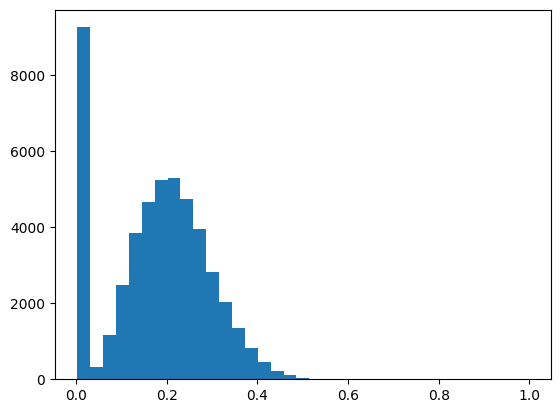

In [ ]:
plt.hist(probs, bins=35)
plt.show()

In [ ]:
final_classify = []
for p in probs:
  if p >= 0.5:
      final_classify.append(1)
  else:
    final_classify.append(0)

In [ ]:
results = final_model_test[['SK_ID_CURR']].copy()
results['TARGET'] = final_classify
results.to_csv("results.csv", index=False)

In [ ]:
results['TARGET'].value_counts(normalize=True)

0    0.998872
1    0.001128
Name: TARGET, dtype: float64

Rather than classify our predictions into 2 groups, approve or have difficulties, we decided that three groups would provide more meaningful insights for Home Credit. The groups would be based off of the probability that the application will have difficulties paying back the loan, with thresholds of:

  * p < 0.3 --> No predicted difficulties
  * 0.3 <= p < 0.4 --> Predicted to possibly have difficulties
  * p >= 0.4 --> Predicted to have difficulties

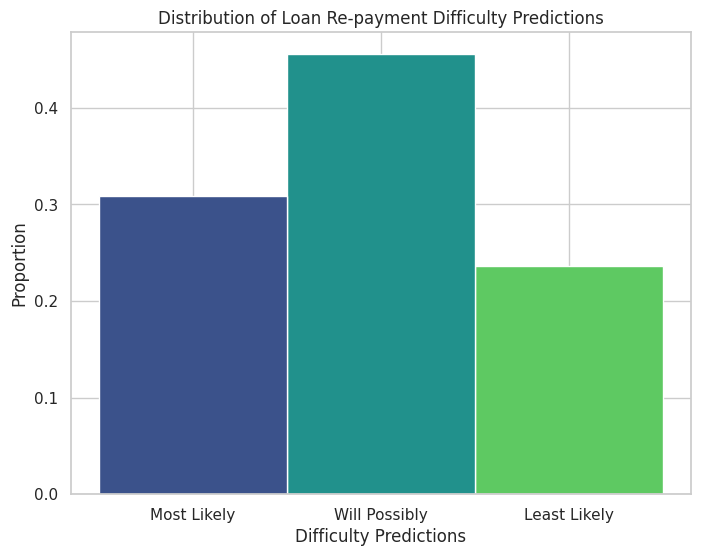

In [ ]:
final_classify = []
for p in probs:
  if p < 0.1:
      final_classify.append('0')
  elif 0.1 <= p < 0.2:
      final_classify.append('0.5')
  elif p >= 0.2:
      final_classify.append('1')

proportions = [final_classify.count(val) / len(final_classify) for val in set(final_classify)]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(x=final_classify, hue=final_classify, palette="viridis", stat='proportion', alpha=1, legend=None)

plt.xlabel("Difficulty Predictions")
plt.ylabel("Proportion")
plt.title("Distribution of Loan Re-payment Difficulty Predictions")
plt.xticks([0, 1, 2], ['Most Likely', 'Will Possibly', 'Least Likely'])

legend_labels = []
# plt.legend(title='', labels=legend_labels)

plt.show()

In [ ]:
proportions

[0.23602904972919744, 0.45552273100279006, 0.30844821926801247]

Above we note that most applicants should not have any difficulties repaying their loans (87%), while only 1.7% of applicants are predicted to definetly have some difficulty repaying their loan.

# Best-performing Fair Model

The model that we selected for best fairness is the linear discriminant analysis model run with our custom splits on the historic data variables. This model recieved a demographic parity score of 0.983, meaning it classifies males and females as likely to have no issues repaying their loans at very similar rates.

This makes sense for our historic data to make similar predictions for both males and females because it is only looking at previous loan repayments and details, without any regard to current application.

Although we selected this model for its fairness, it performs relatively well in other metrics compared to some of the other models that we implemented. Its reported accuracy is 67%, and its ROC AUC is 0.555. The model reported an F1 score of 0.0829, while having a false positive rate of 3.1%.

While these metrics might be on par with many of the other models we fit, they do not stack up to those produced from our final model. The final model's accuracy of 67.9% is slightly higher than our fair model's, but the false positive rate is slightly higher at 5.8%. The metrics that separate the performance of the two models are ROC AUC and F1 score, both of which were much higher in our final model.

The demographic parity of our final model is just 0.261, illustrating quite a large conflict between fairness and prediction performance.

# Comparisons Across Models Using Random Split

In [ ]:
models = [education_work_data, personal_data, loan_data, history_data, best_data, full_data]
lr = []
svm = []
lda = []
i = 0
for p in models:
  if p.equals(personal_data) or p.equals(full_data):
    mod = True
  else:
    mod = False
  lda.append(pd.DataFrame(prediction_metrics(p, 'TARGET', 'lda', 'random', protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=mod), index=[i]))
  svm.append(pd.DataFrame(divide_svm(p.sample(frac = 1), 'random', mod), index=[i]))
  lr.append(pd.DataFrame(prediction_metrics(p, 'TARGET', 'logistic_ridge', 'random', 0.5, protected_val = 1, protected_col = "GENDER_FLAG", protected_in_model=mod), index=[i]))
  i += 1

Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predictions associated with paying back a loan
Note: neither group received any predict

In [ ]:
lda_col = ["LDA"] * len(lda)
svm_col = ["SVM"] * len(svm)
lr_col = ["LR"] * len(lr)

lda_df = pd.concat([d for d in lda], ignore_index=True)
lda_df["Model"] = lda_col
svm_df = pd.concat([d for d in svm], ignore_index=True)
svm_df["Model"] = svm_col
lr_df = pd.concat([d for d in lr], ignore_index=True)
lr_df["Model"] = lr_col

metric_compare = pd.concat([lda_df, svm_df, lr_df], ignore_index=True)
metric_compare.replace([np.inf], np.nan, inplace=True)

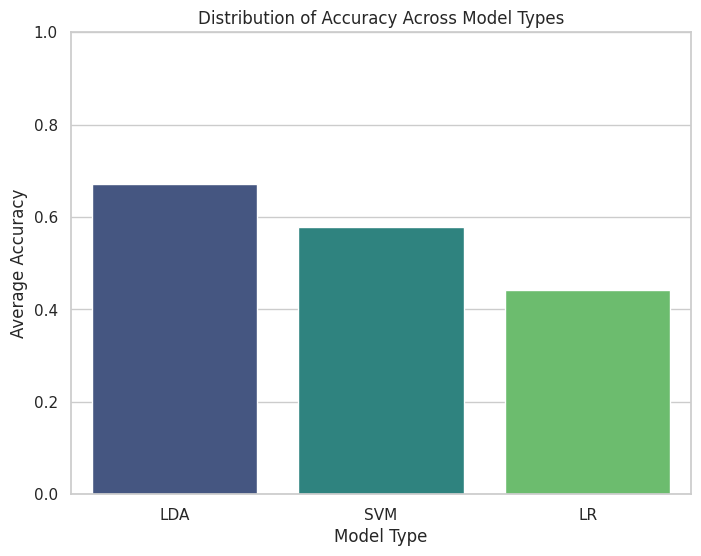

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data = metric_compare, x="Model", y = "accuracy", palette="viridis", errorbar=None)

plt.xlabel("Model Type")
plt.ylabel("Average Accuracy")
plt.title("Distribution of Accuracy Across Model Types")
plt.ylim(0, 1)


plt.show()

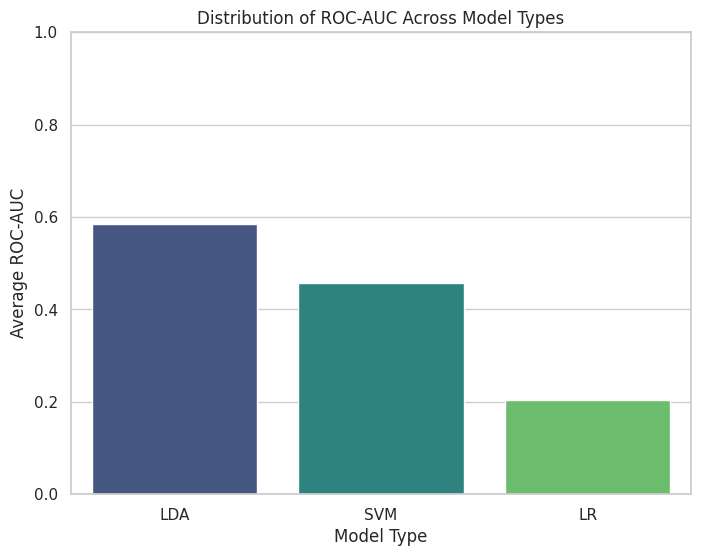

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data = metric_compare, x="Model", y = "roc_auc", palette="viridis", errorbar=None)

plt.xlabel("Model Type")
plt.ylabel("Average ROC-AUC")
plt.title("Distribution of ROC-AUC Across Model Types")
plt.ylim(0, 1)


plt.show()

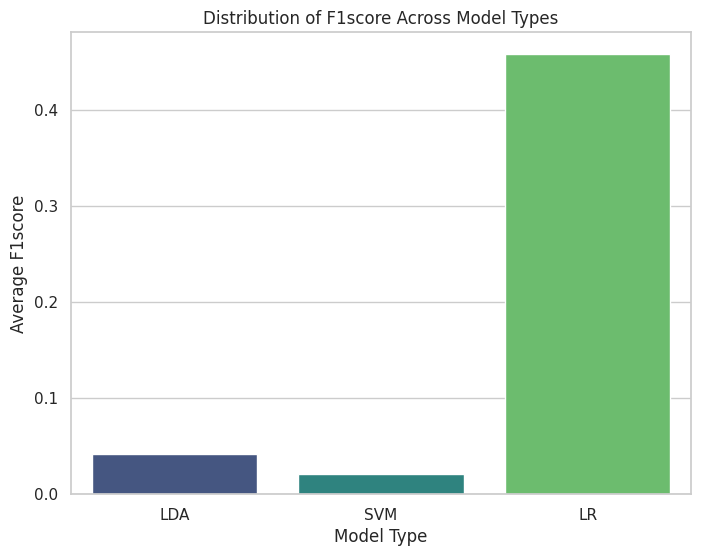

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data = metric_compare, x="Model", y = "f1", palette="viridis", errorbar=None)

plt.xlabel("Model Type")
plt.ylabel("Average F1score")
plt.title("Distribution of F1score Across Model Types")

plt.show()

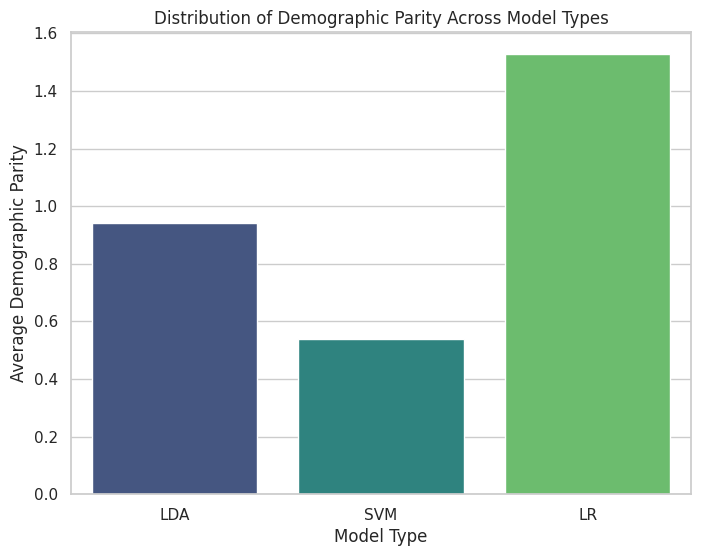

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data = metric_compare, x="Model", y = "demo_parity", palette="viridis", errorbar=None)

plt.xlabel("Model Type")
plt.ylabel("Average Demographic Parity")
plt.title("Distribution of Demographic Parity Across Model Types")

plt.show()

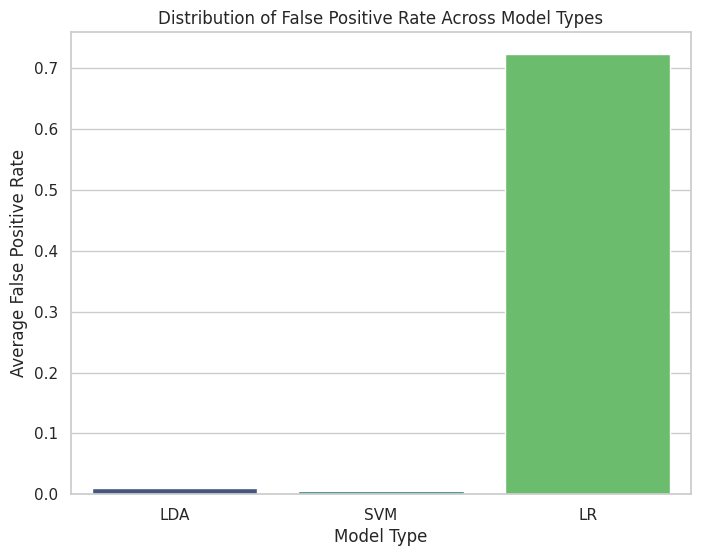

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data = metric_compare, x="Model", y = "fp_rate", palette="viridis", errorbar=None)

plt.xlabel("Model Type")
plt.ylabel("Average False Positive Rate")
plt.title("Distribution of False Positive Rate Across Model Types")

plt.show()

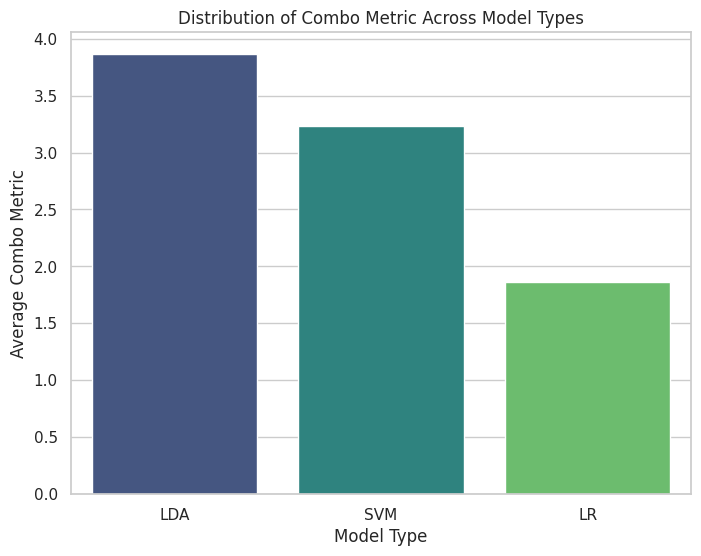

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(data = metric_compare, x="Model", y = "combo", palette="viridis", errorbar=None)

plt.xlabel("Model Type")
plt.ylabel("Average Combo Metric")
plt.title("Distribution of Combo Metric Across Model Types")

plt.show()

# Results

**Accidentally put lda for lr metrics, will update once runs**